<h1>CS166: Traffic Simulation Assignment</h1>
<h2>Part 1: Traffic Jams on a Circular Road</h2>
<h3>Nagel-Schreckenberg Model</h3>

Single-lane, Variable speed, Traffic Model

In [440]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
sns.set()
%matplotlib inline

In [622]:
class TrafficSim:

    def __init__(self, length=100, no_of_lanes=1, car_density=0.3, slow_down_prob=0.5, max_speed=5, demo = False):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the lane. 
                Default: 100.
            
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 1.

            car_density (float) The fraction of cells that have a car on them.
                Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
                slow down by 1 during an update step. 
                Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
                Default: 5.
              
            demo (bool) If True, will display the lane along with all the cars on it.
                Default: False
        '''
        self.demo = demo
        self.length = length
        self.car_density = car_density
        self.no_of_lanes = no_of_lanes
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        #set state by creating the lane(s)
        self.state = self.create_lane()
            
            
    def create_lane(self):
        '''
        Initializes lane according to road length, car density, and number of lanes.
        '''
            
        #choose random indexes to place the cars
        random_indexes = np.random.choice(range(self.length*self.no_of_lanes),                   
                                                size=int(round(self.car_density * self.length * self.no_of_lanes)),                
                                                replace=False)
        
        # -1 means empty cell
        state = -np.ones(self.length*self.no_of_lanes, dtype=int)  
        
        #place cars with random velocities along the lane
        state[random_indexes] = np.random.randint(0, self.max_speed + 1, 
                                                      size=len(random_indexes))
    
        return np.split(state, self.no_of_lanes) 
    
        
    def get_distances(self, curr_lane, index):
        '''
        Get the front and back distances of the given car.
        Distance is the number of empty cells between current car and next car plus 1.
        
        Inputs: 
        
            curr_lane: The current road that the car is on (numpy array)
            index: The index of the current car.
            
        Outputs: 
            
            front_dist: The available front distance of the current car.
            back_dist: The available back distance of the current car.
            
        '''
        
        front_dist, back_dist = 1,1

        while curr_lane[(index + front_dist) % len(curr_lane)] == -1:
            front_dist += 1
            if front_dist >= 6: break
        while curr_lane[(index - back_dist) % len(curr_lane)] == -1:
            back_dist += 1
            if back_dist >= 6: break
                
        return front_dist, back_dist  
    
    def update_cars(self):
        '''
        Update car velocities.
        
        For single-lane model, the following checks are implemented:
        
        - acceleration:
        All cars not at the maximum velocity have their velocity increased by one unit.
        
        - deceleration:
        If the front distance is smaller than the velocity, the velocity is reduced to (distance-1). 
        
        - randomization:
        Cars that have a velocity >= 1 have their speed reduced by one unit with a probability of p.
        '''
        for i in range(self.length):
            #if the index is a car
            if self.state[0][i] != -1: 
                
                #get the front and back distances of the current car
                f_dist, b_dist = self.get_distances(self.state[0],i)
                
                #Acceleration
                if self.state[0][i] + 1 < f_dist:
                    self.state[0][i] = min(self.state[0][i] + 1, self.max_speed)
                
                #Deceleration
                else: self.state[0][i] = max(f_dist - 1, 0)
                
                #Randomization
                if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                    self.state[0][i] -= 1
        
    def move_cars(self):
        
        '''
        Move cars according to their updated velocities.
        '''
        
        # initialize new empty state according to length and number of lanes
        new_state = np.split(-np.ones(self.length*self.no_of_lanes, dtype=int), self.no_of_lanes)
        
        #loop through updated velocities from the old lane
        #and move cars to new positions in the new lane
        for lane in range(self.no_of_lanes):
            for i in range(self.length):
                if self.state[lane][i] != -1:
                    new_state[lane][(i + self.state[lane][i]) % self.length] = self.state[lane][i]
                    
        return new_state  

    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #update car velocities
        self.update_cars()

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #Move cars 
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

    def get_traffic_flow(self):
        '''
        Traffic flow is calculated as the number of cars that pass the periodic boundary per time step.
        This function updates the time step by 1, and updates the number of cars that have passed 
        the periodic boundary at a given time step.
        '''
        self.time_step += 1
        for lane in range(len(self.state)):
            for i in range(self.max_speed):
                if self.state[lane][i] > i:
                    self.cumulative_traffic_flow += 1
                    
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.no_of_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.state[lane]))
        print()
        

In [623]:
np.random.seed(2000)

sim = TrafficSim(car_density=0.9,demo=True)
print("Initial state")
sim.display()
print("Implementing state updates")
for i in range(10):
    sim.step()

Initial state
00425051340211.1303402042405.040500235404313115444.401..4142202050000321.3212..051303010415233.1435.

Implementing state updates
00000000000000.0000000000001.000000000000000000001.002..0000000000000000.0002..000000000000001.0001.

00000000000000.000000000001.000000000000000000001.001..00000000000000001.001..000000000000001.0000.0

00000000000000.00000000000.000000000000000000000.001.1.0000000000000001.000.1.00000000000000.00000.0

00000000000000.00000000001.000000000000000000000.01.1.0000000000000001.0000..000000000000000.00000.0

00000000000001.0000000000.0000000000000000000000.0.0.0000000000000000.00001..000000000000000.00000.0

0000000000000.00000000001.0000000000000000000001.0.1.0000000000000000.0000.1.000000000000001.00001.0

0000000000000.0000000000.0000000000000000000000.01..00000000000000000.0000..000000000000000.00000.00

0000000000000.0000000001.0000000000000000000001.1.1.00000000000000000.0001..000000000000000.00001.00

0000000000001.000000001.00000000000000000

In [611]:
def sim_diff_density(traffic_sim, density=np.arange(0,1.05,0.05), n_loops=100):
    
    '''
    Run traffic simulation at different densities to analyze traffic behavior.
    For each loop in n_loops, the simulation is updated by 100 steps.
    
    Inputs:
        
    traffic_sim (obj) The traffic simulation object.
                
    density (arr) The different levels of traffic density to test for.
        Default: np.arange(0,1.05,0.05)

    n_loops (int) The number of times to run the simulation.
        Default: 100
        
    Outputs:
    
    avg_traffic_flows (lst) Traffic flows for each density (count: n_loops)
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    '''
    avg_traffic_flows = []
    mean_traffic_flows = []
    CI_traffic_flows = []

    for i in density:

        temp = []

        
        for t in range(n_loops):
            #initialize the sim with a given density
            sim = traffic_sim(car_density=i)
            
            #update the sim 100 times
            for j in range(100):
                sim.step()

            #get the traffic flow for a given density
            avg_traffic_flows.append((i, sim.cumulative_traffic_flow / sim.time_step))
            temp.append(sim.cumulative_traffic_flow / sim.time_step)

        #mean traffic flow for a given density
        mean_traffic_flows.append(np.mean(temp))
        
        #95 CI of traffic flow for a given density
        CI_traffic_flows.append(np.percentile(temp,[2.5,97.5]))
        
    return avg_traffic_flows, mean_traffic_flows, CI_traffic_flows
    
def plot_flow(avg_traffic_flows, mean_traffic_flows, CI_traffic_flows, density=np.arange(0,1.05,0.05)):
    '''
    Plots the traffic flows, mean and 95% CI across different densities.
    x-axis: range of densities
    y-axis: traffic flow value
        
    Inputs:
    
    avg_traffic_flows (lst) Traffic flows for each density
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    density (arr) The different levels of traffic density.
        Default: np.arange(0,1.05,0.05)
    
    '''
    traffic_flows = np.array(avg_traffic_flows)
    plt.figure(figsize=(10,6))
    
    plt.scatter(traffic_flows[:,0],traffic_flows[:,1], alpha = 0.5, c="orange")
    plt.plot(density, mean_traffic_flows)
    plt.plot(density, np.array(CI_traffic_flows)[:,0], ls='dashed')
    plt.plot(density, np.array(CI_traffic_flows)[:,1], ls='dashed')
    
    plt.title("Plot of Traffic Density vs Traffic Flow",size=15)
    plt.xlabel("Traffic Density",size=15)
    plt.ylabel("Traffic flow",size=15)
    plt.show()
    
def plot_df(mean_traffic_flows, CI_traffic_flows, density=np.arange(0,1.05,0.05)):
    '''
    Creates dataframe of the mean traffic flows and 95% CI across different densities.
        
    Inputs:
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    density (arr) The different levels of traffic density.
        Default: np.arange(0,1.05,0.05)
    
    '''
    df = pd.DataFrame({
    'Traffic Density':density,
    'Mean flow':mean_traffic_flows,
    '95 CI':CI_traffic_flows
    })
    return df

In [612]:
single_lane_traffic_flows, single_lane_mean, single_lane_CI = sim_diff_density(TrafficSimulation) 


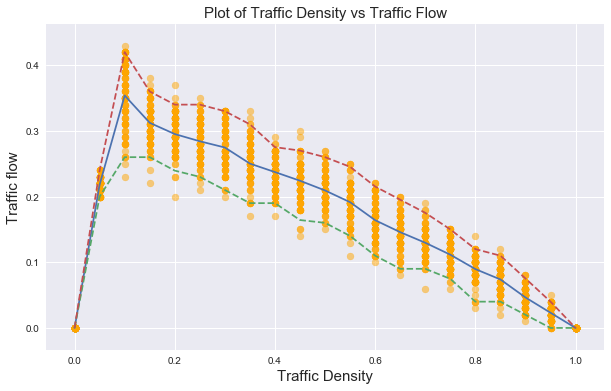

,Traffic Density,Mean flow,95 CI
0,0.00,0.0000,"[0.0, 0.0]"
1,0.05,0.2182,"[0.2, 0.24]"
2,0.10,0.3539,"[0.26, 0.42]"
3,0.15,0.3123,"[0.26, 0.36]"
4,0.20,0.2952,"[0.2395, 0.34]"
5,0.25,0.2842,"[0.23, 0.34]"
6,0.30,0.2747,"[0.21, 0.33]"
7,0.35,0.2502,"[0.19, 0.31]"
8,0.40,0.2373,"[0.19, 0.27524999999999994]"
9,0.45,0.2241,"[0.16425, 0.27]"


In [613]:
plot_flow(single_lane_traffic_flows, single_lane_mean, single_lane_CI)
single_lane_df = plot_df(single_lane_mean, single_lane_CI)
single_lane_df

<h2>Part 2: Multi-lane Highways</h2>
<h3>Two-lane Traffic Simulation Model</h3>

Two-lane, symmetric, uni-directional, variable speed model.

In [614]:
class TrafficSimTwoLane(TrafficSim):

    def __init__(self, length=100, no_of_lanes = 2, car_density=0.3, slow_down_prob=0.5, switch_lane_prob=1, max_speed=5, demo = False):
        
        '''
        TrafficSimTwoLane inherits from the TrafficSim parent class.
        The no_of_lanes is now defaulted at 2.
        A new variable, switch_lane_prob, is introduced.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                    given that a lane switch is possible. 
                Default: 1.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #initialize new variable, switch-lane_prob
        self.switch_lane_prob = switch_lane_prob
    
    def update_cars(self,old_state,curr_lane_index,other_lane_index):
        '''
        Update car velocities with/without lane switch.
        
        For two-lane model, the following checks are implemented:
        
        - acceleration:
        All cars not at the maximum velocity have their velocity increased by one unit.
        
        - lane switch:
        If car cannot accelerate in current lane, and there is sufficient front and back distance
        in the other lane, the car will switch to the other lane with probability = switch_lane_prob
        
        - deceleration:
        If the car cannot accelerate or switch lanes, the car decelerates. 
        The velocity is reduced to (distance-1).
        
        - randomization:
        Cars that have a velocity >= 1 have their speed reduced by one unit with a probability of p.
        
        Inputs:
        
            old_state (arr) A deep copy of the last updated state as reference when
                                    updating both lanes
                
            curr_lane_index (int) The index of the current lane that the car is on.
                                    
            other_lane_index (int) The index of the other lane that the car can switch to.
        '''

        for i in range(self.length):
            #if the index is a car
            if old_state[curr_lane_index][i] != -1: 
                
                #get front and back distance of current lane
                f_dist, b_dist = self.get_distances(old_state[curr_lane_index], i)
                
                #get front and back distance of other lane
                fo_dist, bo_dist = self.get_distances(old_state[other_lane_index], i)
                
                #Acceleration in current lane
                if old_state[curr_lane_index][i] + 1 < f_dist:
                    self.state[curr_lane_index][i] = min(old_state[curr_lane_index][i] + 1, self.max_speed)
                
                else: #if acceleration is not possible:

                    #if switching lanes is possible, switch lane with probability switch_lane_prob.
                    if old_state[curr_lane_index][i] + 1 <= fo_dist and bo_dist >= self.max_speed:
                        if np.random.uniform() < self.switch_lane_prob:
                            self.state[other_lane_index][i] = min(old_state[curr_lane_index][i] + 1, self.max_speed)
                            self.state[curr_lane_index][i] = -1

                    #if switching lanes is not possible, decelerate in current lane
                    else: self.state[curr_lane_index][i] = max(f_dist - 1, 0)

                # Random slow down
                if (old_state[curr_lane_index][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                    self.state[curr_lane_index][i] -= 1

        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities / switch lanes and update velocities
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

        
        

In [615]:
np.random.seed(2000)

sim = TrafficSimTwoLane(no_of_lanes=2, car_density=0.9, demo=True)
print("Initial state")
sim.display()
print("Implementing state updates")
for i in range(10):
    sim.step()
    

Initial state
1.3444521214.4..055410125240.05120041103132.5.35101303.51323012033402200.345422013054350250.15255012
32344341102410324253213..03121203044141553211505345.2442.1552453311.2052415251.413..0103422200.2.241

Implementing state updates
1.0000000001.2..000000000001.00000000000001.1.00000001.00000000000000001.000000000000000001.00000000
00000000000000000000002..00000000000000000000000001.0001.0000000001.0000000001.002..0000000001.1.000

.0000000001.2..000000000001.00000000000001.1.00000001.00000000000000001.000000000000000001.000000001
0000000000000000000001..00000000000000000000000001.0001.0000000001.0000000001.001..0000000001.1.0000

0000000001.2..000000000001.00000000000001.1.00000001.00000000000000001.000000000000000001.000000001.
000000000000000000001.1.0000000000000000000000001.0001.0000000001.0000000001.001.1.000000001.1.00000

000000001.2..000000000001.00000000000001.1.00000001.00000000000000001.000000000000000001.000000001.0
00000000000000000001.1.00000000000000000000000

In [618]:
two_lane_traffic_flows, two_lane_mean, two_lane_CI = sim_diff_density(TrafficSimTwoLane) 
    

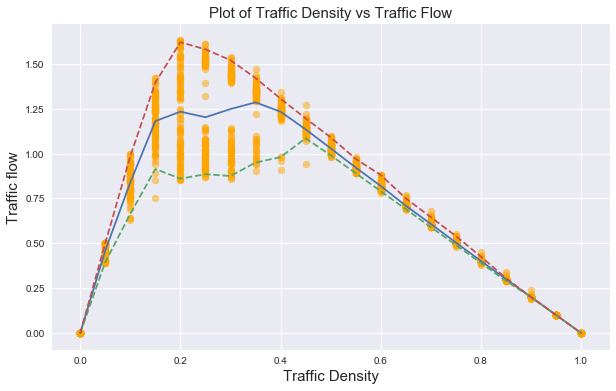

,Traffic Density,Mean flow,95 CI
0,0.00,0.0000,"[0.0, 0.0]"
1,0.05,0.4591,"[0.39475000000000005, 0.5]"
2,0.10,0.8392,"[0.6637500000000001, 0.98525]"
3,0.15,1.1805,"[0.9137500000000001, 1.3952499999999999]"
4,0.20,1.2331,"[0.86, 1.62]"
5,0.25,1.2019,"[0.8847499999999999, 1.58]"
6,0.30,1.2477,"[0.87475, 1.52]"
7,0.35,1.2848,"[0.9495, 1.42]"
8,0.40,1.2327,"[0.98, 1.30525]"
9,0.45,1.1345,"[1.08475, 1.19525]"


In [619]:
plot_flow(two_lane_traffic_flows, two_lane_mean, two_lane_CI)
two_lane_df = plot_df(two_lane_mean, two_lane_CI)
two_lane_df

Todo:
- think about problematic driver behavior to implement
- try implementing 3 lane model
- For stretch goal 2 items: should we be trying to implement all those things at once, or just one at a time? 

Potential HCs: 
- estimation (estimating the traffic flow on 3-lane or higher models)
- descriptivestats
- confidenceinterval (explaning the confidence intervals included in the traffic flow plot)
- systemdynamics (identify potential attractor states - what are the typical "stable states" of the models?)
- studyreplication (replicating nagel-schreckenberg and rickert et al.'s models + extending on them)

Questions for Scheffler:

- For two-lane:
    - should car_density mean density of the whole system? For example, should 0.1 density for a single-lane == 0.2 density for the two-lane, or 0.1 density for the whole two-lane system (which means 0.05 density per lane for the whole two-lane system)?
    - adding on to that, should we let the user define the density for lane 1 and lane 2, or should they just put the density for the whole system and we randomize the ratio split? Or should we always split the ratio in half, etc.?
    
    
- Where should methods go? Should they go inside the method that they're referenced in (like a sub-method) if they aren't used in other methods in the class?

- Should we be doing class-inheritance and all that? Will we be down-graded for having two separate classes eventho hypothetically speaking the models should be similar enough that they could be built off the same class?